# Approach 1a: Basic frame differencing
For this most basic approach, we compare each motion image $M$ to the closest lapse image $L$ and take the
1. mean absolute pixel-wise difference $ \frac{1}{xy} \sum_{x,y} | M_{x,y} - L_{x,y} | $
2. mean squared pixel-wise difference $ \frac{1}{xy} \sum_{x,y} (M_{x,y} - L_{x,y})^2 $
M and L are both grayscale.

**Reasoning:** We assume that anomalous images highly differ from the closest lapse image in a significant amount of pixels while normal images only have low pixel differences.

### Suspected problems
- **Noise** (we scale the images down for performance reasons which also reduces noise a bit)
- **Small object movements** that are not of interest (such as leaves, dust particles, etc.)
- Very sensitive to **camera movement** (which seems to happen a lot in the dataset)
- Since we eliminate the **color information**, a deer might look very much like a forest.

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from py.Dataset import Dataset
from py.DatasetStatistics import DatasetStatistics
from py.Session import Session, MotionImage, LapseImage
from py.FileUtils import list_folders, list_jpegs_recursive
from py.ImageUtils import display_images

DIR = '/home/AMMOD_data/camera_traps/BayerWald/Vielkadaver-Projekt/' # dataset directory
SCALE = 0.2 # scaling factor for all images

ds = Dataset(DIR)
session = ds.create_session("beaver_01")

Found 32 sessions
Session 'Beaver_01' at folder: /home/AMMOD_data/camera_traps/BayerWald/Vielkadaver-Projekt/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


## Experiment 1: Basic classifier
The proposed classifier computes the following features
- mean of absolute pixel-wise difference _absmean_
- variance of absolute pixel-wise difference _absvar_
- mean of squared pixel-wise difference _sqmean_
- var of squared pixel-wise difference _sqvar_

In [3]:
from py.ImageClassifier import AbstractImageClassifier

class FrameDiffClassifier(AbstractImageClassifier):
    def evaluate(self, motion_img: MotionImage, display=False):
        before_img, after_img, rel = motion_img.get_closest_lapse_images()
        comp_img = before_img if rel <= 0.5 else after_img
        motion_arr = motion_img.read(scale=SCALE, gray=True)
        comp_arr = comp_img.read(scale=SCALE, gray=True)

        absdiff = abs(motion_arr - comp_arr)
        sqdiff = (motion_arr - comp_arr) ** 2
        absmean = np.average(absdiff)
        absvar = np.var(absdiff)
        sqmean = np.average(sqdiff)
        sqvar = np.var(sqdiff)

        if display:
            display_images([motion_arr, comp_arr, absdiff, sqdiff], ["Motion image", "Closest lapse image", f"abs mean = {absmean}, var = {absvar}", f"sq mean = {sqmean}, var = {sqvar}"], cmap="gray")

        return absmean, absvar, sqmean, sqvar

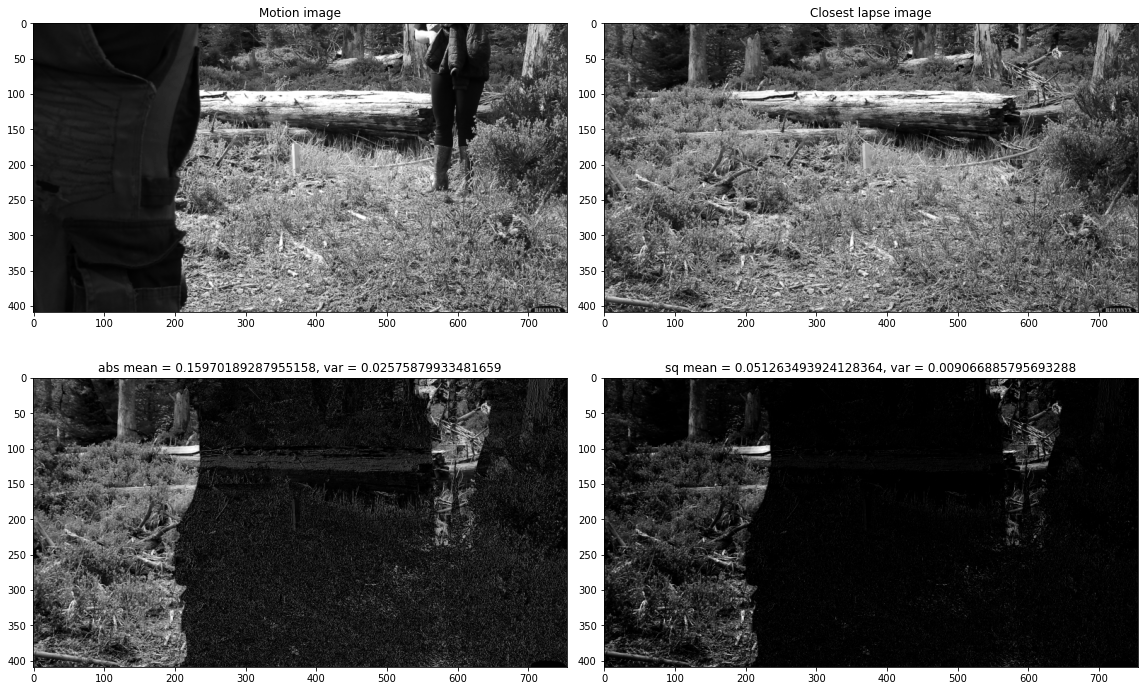

(0.15970189287955158,
 0.02575879933481659,
 0.051263493924128364,
 0.009066885795693288)

In [4]:
img = session.get_random_motion_image(day_only=True)
classifier = FrameDiffClassifier()
classifier.evaluate(img, display=True)

The anomalous object is usually clearly visible in the difference image but there are still a lot of unwanted artefacts around it (possibly because of small object movement and noise).

In [42]:
def generate_test_scores(classifier):
    normal_scores = []
    anomalous_scores = []
    bird_scores = []
    normal_i = [3, 4, 5, 48, 49, 50, 51, 52, 53, 54, 55, 78, 79, 80]
    bird_i = list(range(86, 106))

    for i in tqdm(range(1, 106)):
        filename = f"Beaver_01_{i:05d}.jpg"
        img = session.get_motion_image_from_filename(filename)
        score = classifier.evaluate(img)
        if i in normal_i:
            normal_scores.append(score)
        elif i in bird_i:
            bird_scores.append(score)
        else:
            anomalous_scores.append(score)
    return normal_scores, anomalous_scores, bird_scores


classifier = FrameDiffClassifier()
normal_scores, anomalous_scores, bird_scores = generate_test_scores(classifier)

  0%|          | 0/105 [00:00<?, ?it/s]

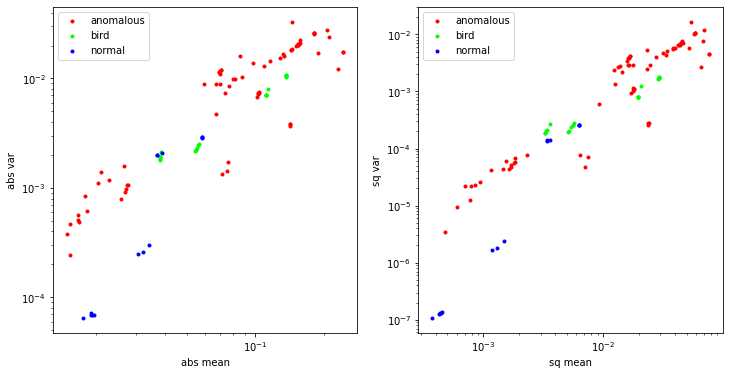

In [60]:
def plot(i1, i2, normal_scores, anomalous_scores, bird_scores):
    titles = ["abs mean", "abs var", "sq mean", "sq var"]
    plt.scatter([ar[i1] for ar in anomalous_scores], [ar[i2] for ar in anomalous_scores], color="red", label="anomalous", marker=".")
    plt.scatter([ar[i1] for ar in bird_scores], [ar[i2] for ar in bird_scores], color="lime", label="bird", marker=".")
    plt.scatter([ar[i1] for ar in normal_scores], [ar[i2] for ar in normal_scores], color="blue", label="normal", marker=".")
    plt.xlabel(titles[i1])
    plt.ylabel(titles[i2])
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot(0, 1, normal_scores, anomalous_scores, bird_scores)
plt.subplot(1, 2, 2)
plot(2, 3, normal_scores, anomalous_scores, bird_scores)
plt.show()

## Experiment 2: Add a Gaussian filter

In [27]:
from py.ImageClassifier import AbstractImageClassifier
from scipy import ndimage

class GaussianFrameDiffClassifier(AbstractImageClassifier):
    def __init__(self, sigma: int):
        self.sigma = sigma
    
    def evaluate(self, motion_img: MotionImage, display=False):
        before_img, after_img, rel = motion_img.get_closest_lapse_images()
        comp_img = before_img if rel <= 0.5 else after_img
        motion_arr = motion_img.read(scale=SCALE, gray=True)
        comp_arr = comp_img.read(scale=SCALE, gray=True)

        motion_arrg = ndimage.gaussian_filter(motion_arr, sigma=self.sigma)
        comp_arrg = ndimage.gaussian_filter(comp_arr, sigma=self.sigma)

        absdiff = abs(motion_arrg - comp_arrg)
        sqdiff = (motion_arrg - comp_arrg) ** 2
        absmean = np.average(absdiff)
        absvar = np.var(absdiff)
        sqmean = np.average(sqdiff)
        sqvar = np.var(sqdiff)

        if display:
            display_images([motion_arr, comp_arr, absdiff, sqdiff], ["Motion image", "Closest lapse image", f"abs mean = {absmean}, var = {absvar}", f"sq mean = {sqmean}, var = {sqvar}"], cmap="gray")

        return absmean, absvar, sqmean, sqvar

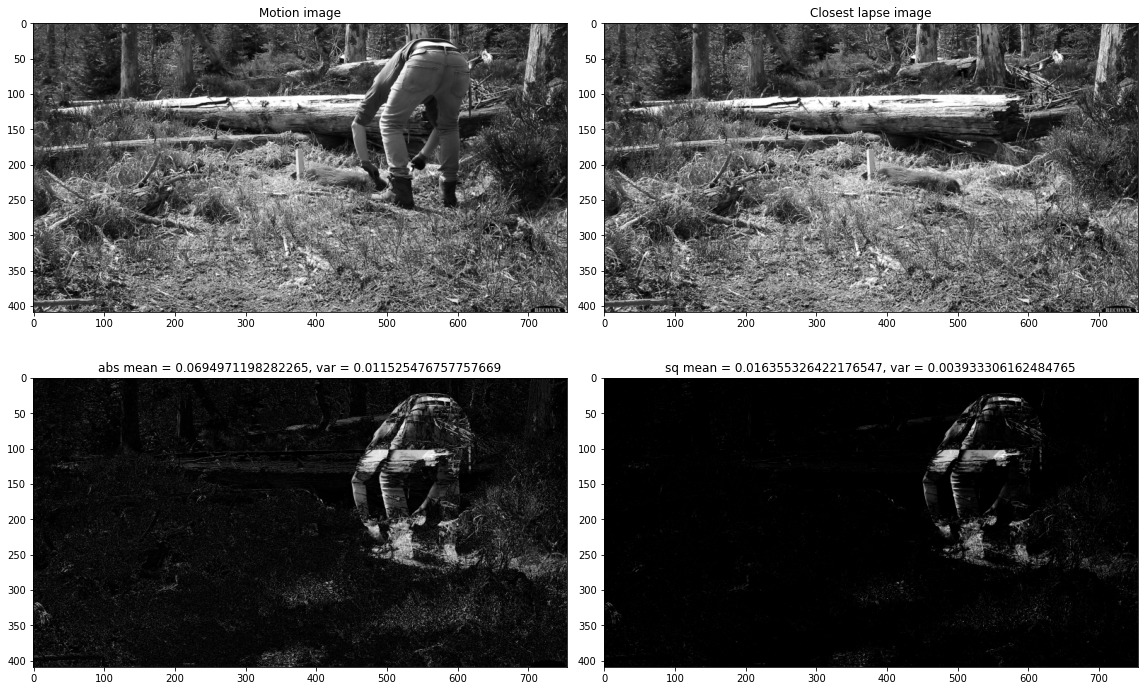

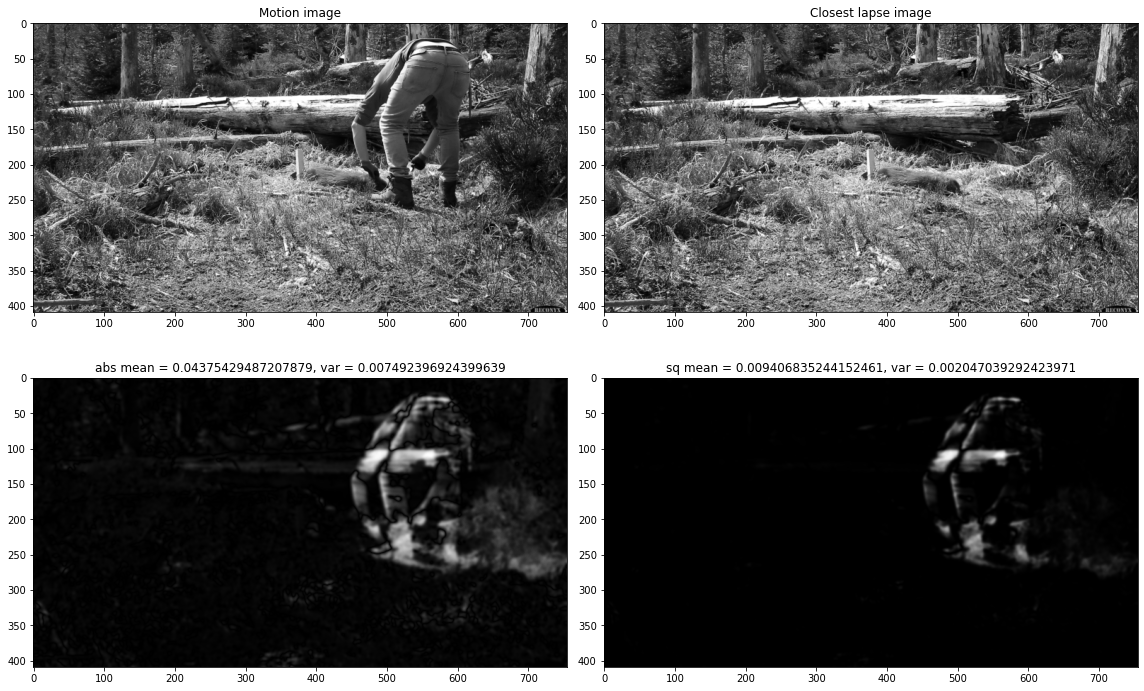

(0.04375429487207879,
 0.007492396924399639,
 0.009406835244152461,
 0.002047039292423971)

In [31]:
img = session.get_random_motion_image(day_only=True)
classifier = FrameDiffClassifier()
classifier.evaluate(img, display=True)
classifier2 = GaussianFrameDiffClassifier(sigma=2)
classifier2.evaluate(img, display=True)

In [45]:
classifier = GaussianFrameDiffClassifier(sigma=2)
normal_scores_g, anomalous_scores_g, bird_scores_g = generate_test_scores(classifier)

  0%|          | 0/105 [00:00<?, ?it/s]

In [48]:
classifier = GaussianFrameDiffClassifier(sigma=4)
normal_scores_g2, anomalous_scores_g2, bird_scores_g2 = generate_test_scores(classifier)

  0%|          | 0/105 [00:00<?, ?it/s]

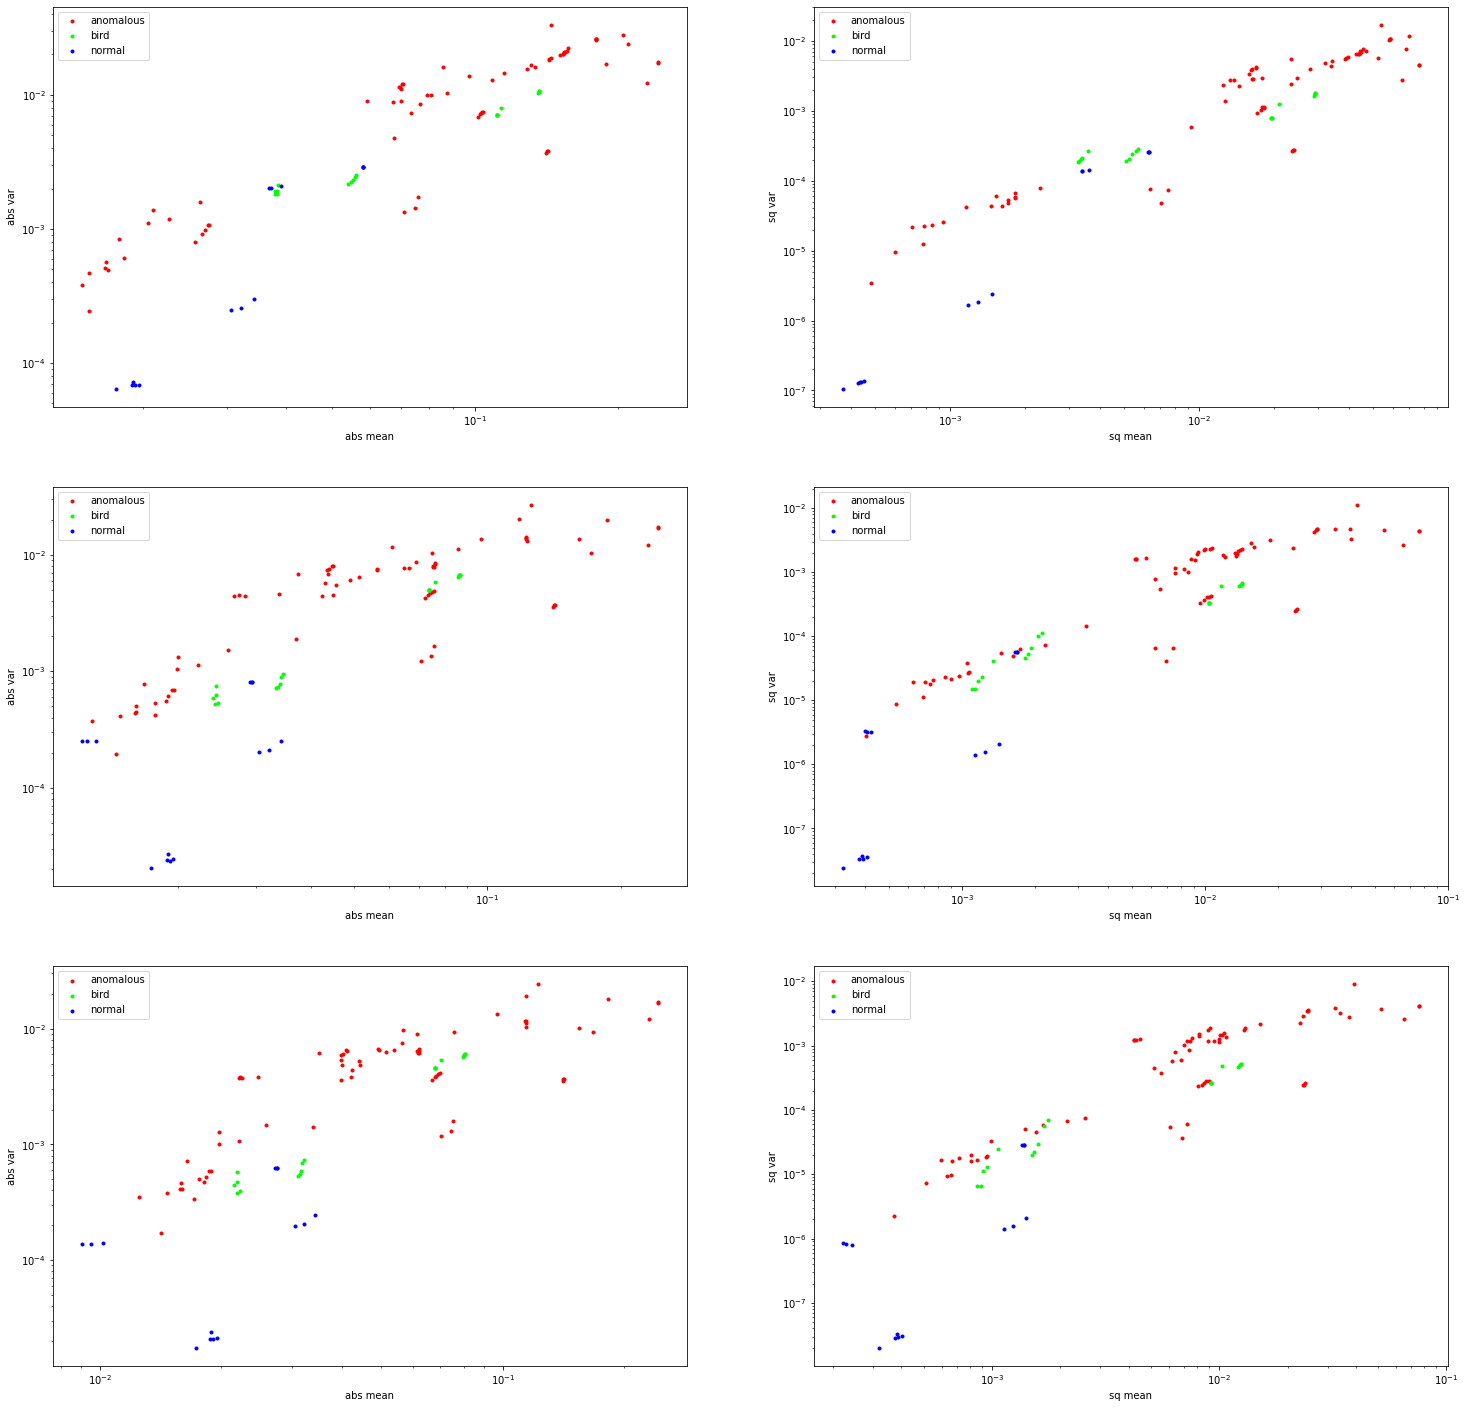

In [61]:
plt.figure(figsize=(25, 25))
plt.subplot(3, 2, 1)
plot(0, 1, normal_scores, anomalous_scores, bird_scores)
plt.subplot(3, 2, 2)
plot(2, 3, normal_scores, anomalous_scores, bird_scores)
plt.subplot(3, 2, 3)
plot(0, 1, normal_scores_g, anomalous_scores_g, bird_scores_g)
plt.subplot(3, 2, 4)
plot(2, 3, normal_scores_g, anomalous_scores_g, bird_scores_g)
plt.subplot(3, 2, 5)
plot(0, 1, normal_scores_g2, anomalous_scores_g2, bird_scores_g2)
plt.subplot(3, 2, 6)
plot(2, 3, normal_scores_g2, anomalous_scores_g2, bird_scores_g2)
plt.show()